In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import copy
import time

### Original version 

In [2]:
def rotate(array, angle_in_degrees):
    import itertools
    (h,w) = array.shape[:2]
    
    result = np.zeros_like(array).astype(np.uint8)
    
    angle = angle_in_degrees * math.pi / 180
    (cosine, sine) = np.cos(angle), np.sin(angle)
    rotation_matrix = [[cosine, sine], [-sine, cosine]]
    
    for x,y in itertools.product(range(w), range(h)):
        pixels = array[y,x,:]
        new_x, new_y = np.matmul(rotation_matrix, [x,y])
        new_x, new_y = int(new_x), int(new_y)
        if 0 <= new_x < w and 0 <= new_y < h:
            result[new_y, new_x, :] = pixels
            
    return result

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


image size:(2332, 3500) | cost time:66.7029 s


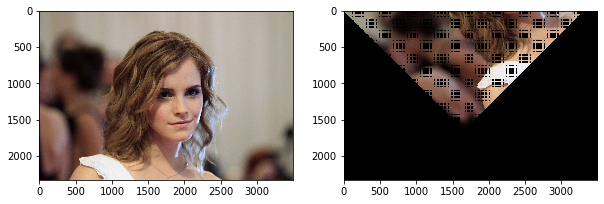

In [3]:
img_bgr = cv2.imread('E:/Desktop/emma2.jpeg',cv2.IMREAD_UNCHANGED)
img_rgb = img_bgr[:,:,::-1]
t1 = time.time()
result = rotate(img_rgb, 45)
fig, axs = plt.subplots(1,2, figsize=(10,18))
axs[0].imshow(img_rgb)
axs[1].imshow(result)
fig.show()
print('image size:%s | cost time:%.4f s'%(img_rgb.shape[:2],(time.time()-t1)))

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


image size:(224, 225) | cost time:0.5117 s


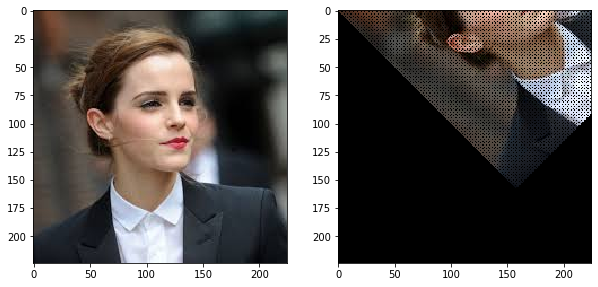

In [4]:
img_bgr = cv2.imread('E:/Desktop/emma.jpg',cv2.IMREAD_UNCHANGED)
img_rgb = img_bgr[:,:,::-1]
t1 = time.time()
result = rotate(img_rgb, 45)
fig, axs = plt.subplots(1,2, figsize=(10,18))
axs[0].imshow(img_rgb)
axs[1].imshow(result)
fig.show()
print('image size:%s | cost time:%.4f s'%(img_rgb.shape[:2],(time.time()-t1)))

### Problem to solve:

1.原本的旋轉矩陣式逆時鐘，此我改為順時鐘。
2. 是以左上角為原點旋轉，且會將照片部分或全部區域切掉。 應改為對影像中心或選定點旋轉，並且保留了全部的 
    影像範圍。 --> full_shape
3. 會出現六邊形的黑點，推測是因為旋轉後沒有每個pixel都對應到，可以改善的方式:
    利用周圍的像素做平均或是其他interpolation --> fill_in_pixel 
4. 當處理高像素的影像，會花特長時間-->(尚未想到除了多進程以外的作法) 

### My version

In [5]:
def fill_in_pixel(img):
    result = copy.deepcopy(img)
    (h,w) = img.shape[:2]
    X = list(np.where(np.mean(img,axis=2) == 0)[0])
    Y= list(np.where(np.mean(img,axis=2) == 0)[1])
    
    for x,y in zip(X,Y):
        if 1 <= x < w-1 and 1 <= y < h-1:
            result[y,x,:] =np.mean((img[y+1,x,:],img[y-1,x,:],img[y, x-1,:],img[y, x+1,:]), axis=0)
            
    return result

In [6]:
def full_shape(shape,center,rotation_matrix):
    xc,yc = center
    (h,w) = shape
    p1 = (w-xc,h-yc)#upper right
    p2 = (-xc, h-yc)#upper left
    p3 = (w-xc, -yc)#lower right
    p4 = (-xc, -yc)#lower left
    pp = np.array([p1,p2,p3,p4]).T
    pp2 = np.matmul(rotation_matrix, pp)
    (h_max,h_min,w_max,w_min) = np.ceil((np.max(pp2[1]), np.min(pp2[1]), np.max(pp2[0]), np.min(pp2[0])))
    return int(h_max), int(h_min), int(w_max), int(w_min)

##### version 1: 
1. 可以選定旋轉中心位置
2. 有加入fill_in_pixel  (效果於version 2 說明)

In [7]:
def rotate_2(array, angle_in_degrees, center = None, fill = False):
    '''
    Deal with the hexagon dots occured when using low pixel image & rotate with the center
    '''
    import itertools
    (h,w) = array.shape[:2]
    result = np.zeros_like(array)
    
    angle = angle_in_degrees * math.pi / 180
    (cosine, sine) = np.cos(angle), np.sin(angle)
    rotation_matrix = [[cosine, -sine], [sine, cosine]]
    
    if center == None:
        mid_y, mid_x = int((h+1)/2), int((w+1)/2)
    else:
        mid_x, mid_y = center
    # [mesh_y, mesh_x] = np.mgrid[-mid_y:h-mid_y, -mid_x:w-mid_x]

    for x,y in itertools.product(range(-mid_x,w-mid_x), range(-mid_y,h-mid_y)):
        pixels = array[y+mid_y,x+mid_x,:]
        new_x, new_y = np.matmul(rotation_matrix, [x,y])
        new_x, new_y = int(new_x)+mid_x, int(new_y)+mid_y
        if 0 <= new_x < w and 0 <= new_y < h:
            result[new_y, new_x, :] = pixels
    if fill == True:
        result = fill_in_pixel(result)
    return result 

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


image size:(224, 225) | cost time:1.2673 s


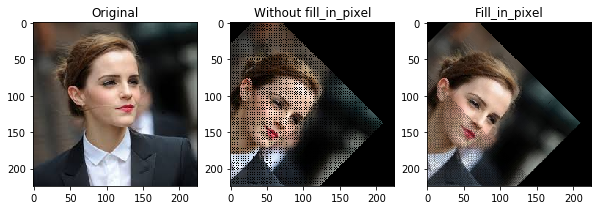

In [8]:
img_bgr = cv2.imread('E:/Desktop/emma.jpg',cv2.IMREAD_UNCHANGED)
img_rgb = img_bgr[:,:,::-1]
t1 = time.time()
result = rotate_2(img_rgb, 45,(50,50),fill=False)
result2 = rotate_2(img_rgb, 45,(50,50),fill=True)
fig, axs = plt.subplots(1,3, figsize=(10,50))
axs[0].imshow(img_rgb)
axs[1].imshow(result)
axs[2].imshow(result2)
axs[0].set_title('Original')
axs[1].set_title('Without fill_in_pixel')
axs[2].set_title('Fill_in_pixel')
fig.show()
print('image size:%s | cost time:%.4f s'%(img_rgb.shape[:2],(time.time()-t1)))

#### version 2:
1. 同樣可以選定旋轉中心位置，但因為我有加入重新計算邊界，故旋轉中心位置地改變會較不明顯。
2. 有加入fill_in_pixel: 在高像素的時候，黑點情況會較不明顯，在低像素則十分明顯。(在spyder plot有此現象，但在jupyter兩者都很明顯) fill in 雖然可以將部分的黑點補上，但會造成部分細節遺失，且部分黑點仍然存在。
3. 關於旋轉影像的黑點，當旋轉角度越大，黑點越明顯。

In [9]:
def rotate_3(array, angle_in_degrees,center=None,fill = False):
    '''
    Deal with the image cut-off, otate with the center 
    the hexagon dots occured when using low pixel image  
    rotate high resolution image is time-costing
    '''
    import itertools
    (h,w) = array.shape[:2]
    result = np.zeros_like(array)
    
    angle = angle_in_degrees * math.pi / 180
    (cosine, sine) = np.cos(angle), np.sin(angle)
    rotation_matrix = [[cosine, -sine], [sine, cosine]]
    
    if center == None:
        mid_y, mid_x = int((h+1)/2), int((w+1)/2)
    else:
        mid_x, mid_y = center
        
    h_max,h_min,w_max,w_min = full_shape((h,w), (mid_x,mid_y), rotation_matrix)
    h2,w2 = (h_max-h_min),(w_max-w_min)
    result = np.zeros((h2,w2,3)).astype(np.uint8)
    
    for x,y in itertools.product(range(-mid_x,w-mid_x,1), range(-mid_y,h-mid_y,1)):
        pixels = array[y+mid_y,x+mid_x,:]
        new_x, new_y = np.matmul(rotation_matrix, [x,y])
        new_x, new_y = int(new_x)+mid_x - (w_min+mid_x) , int(new_y)+mid_y - (h_min+mid_y)
        if 0 <= new_x < (w_max-w_min) and 0 <= new_y < (h_max-h_min):
            result[new_y, new_x, :] = pixels
    #plt.imshow(result)
    if fill == True:
        result = fill_in_pixel(result)
    return result 

-- Test 1:
    Low pixel, 大角度旋轉,
    
    照片邊界延伸,可以選定center,可選擇fill_in_pixel

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


image size:(224, 225) | cost time:2.3237 s


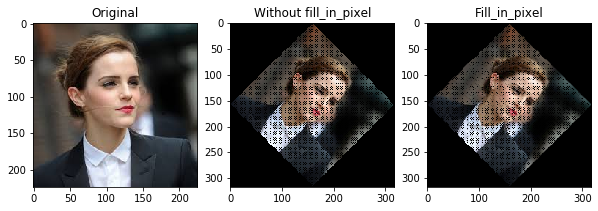

In [10]:
img_bgr = cv2.imread('E:/Desktop/emma.jpg',cv2.IMREAD_UNCHANGED)
img_rgb = img_bgr[:,:,::-1]
t1 = time.time()
result = rotate_3(img_rgb, 45,(50,50),fill=False)
result2 = rotate_3(img_rgb, 45,(50,50),fill=True)
fig, axs = plt.subplots(1,3, figsize=(10,50))
axs[0].imshow(img_rgb)
axs[1].imshow(result)
axs[2].imshow(result2)
axs[0].set_title('Original')
axs[1].set_title('Without fill_in_pixel')
axs[2].set_title('Fill_in_pixel')
fig.show()
print('image size:%s | cost time:%.4f s'%(img_rgb.shape[:2],(time.time()-t1)))

-- Test 1:
    Low pixel, 小角度旋轉,
    
    照片邊界延伸,可以選定center,可選擇fill_in_pixel

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


image size:(224, 225) | cost time:1.2473 s


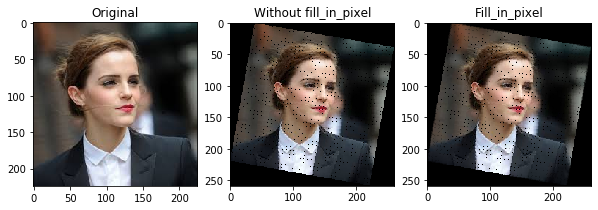

In [15]:
img_bgr = cv2.imread('E:/Desktop/emma.jpg',cv2.IMREAD_UNCHANGED)
img_rgb = img_bgr[:,:,::-1]
t1 = time.time()
result = rotate_3(img_rgb, 10,(50,50),fill=False)
result2 = rotate_3(img_rgb, 10,(50,50),fill=True)
fig, axs = plt.subplots(1,3, figsize=(10,50))
axs[0].imshow(img_rgb)
axs[1].imshow(result)
axs[2].imshow(result2)
axs[0].set_title('Original')
axs[1].set_title('Without fill_in_pixel')
axs[2].set_title('Fill_in_pixel')
fig.show()
print('image size:%s | cost time:%.4f s'%(img_rgb.shape[:2],(time.time()-t1)))

-- Test 2:
    High pixel, 大角度旋轉,
    
    照片邊界延伸,可以選定center,可選擇fill_in_pixel

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


image size:(2332, 3500) | cost time:459.5702 s


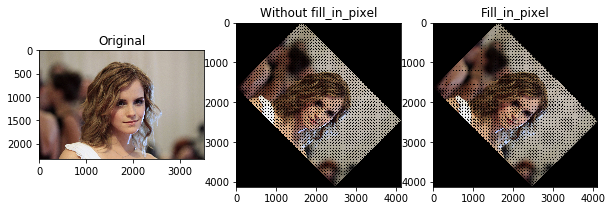

In [12]:
img_bgr = cv2.imread('E:/Desktop/emma2.jpeg',cv2.IMREAD_UNCHANGED)
img_rgb = img_bgr[:,:,::-1]
t1 = time.time()
result = rotate_3(img_rgb, 45,(50,50),fill=False)
result2 = rotate_3(img_rgb, 45,(50,50),fill=True)
fig, axs = plt.subplots(1,3, figsize=(10,30))
axs[0].imshow(img_rgb)
axs[1].imshow(result)
axs[2].imshow(result2)
axs[0].set_title('Original')
axs[1].set_title('Without fill_in_pixel')
axs[2].set_title('Fill_in_pixel')
fig.show()
print('image size:%s | cost time:%.4f s'%(img_rgb.shape[:2],(time.time()-t1)))

-- Test 2:
    High pixel, 小角度旋轉,
    
    照片邊界延伸,可以選定center,可選擇fill_in_pixel

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


image size:(2332, 3500) | cost time:172.1925 s


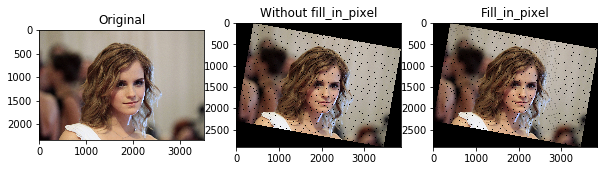

In [13]:
img_bgr = cv2.imread('E:/Desktop/emma2.jpeg',cv2.IMREAD_UNCHANGED)
img_rgb = img_bgr[:,:,::-1]
t1 = time.time()
result = rotate_3(img_rgb, 10,(50,50),fill=False)
result2 = fill_in_pixel(result)
fig, axs = plt.subplots(1,3, figsize=(10,30))
axs[0].imshow(img_rgb)
axs[1].imshow(result)
axs[2].imshow(result2)
axs[0].set_title('Original')
axs[1].set_title('Without fill_in_pixel')
axs[2].set_title('Fill_in_pixel')
fig.show()
print('image size:%s | cost time:%.4f s'%(img_rgb.shape[:2],(time.time()-t1)))